### Import Libraries

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.distributions as dist
from torchsummary import summary
import math
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path
import re
from skimage.metrics  import structural_similarity as ssim

from importlib import reload
import visualization

# locals
import model_architectures

reload(model_architectures)
from model_architectures import VAE, Data3D, VAELatent

reload(visualization)
from visualization import brain_diff

### Define Paths

In [2]:
research_dir = r"D:/school/research"
code_dir = os.path.join(research_dir, "code")
model_dir = os.path.join(code_dir, "explore_again", "models")
data_dir = os.path.join(research_dir, "data")
dhcp_rel2 = os.path.join(data_dir, "dhcp_rel2")
processed_dir = os.path.join(dhcp_rel2, "processed")
volume_dir = os.path.join(processed_dir, "volumes")
l1_dir = os.path.join(volume_dir, "l1")
l5_dir = os.path.join(volume_dir, "l5")

### Get Data

In [3]:
np.random.seed(42)
num_samples = int(len(os.listdir(l1_dir)) / 2)
samples = np.array([i for i in range(0, num_samples)])
np.random.shuffle(samples)

split_val = int(0.8 * num_samples)
train_indices = samples[0:split_val]
val_indices = samples[split_val:]

num_test = int(len(os.listdir(l5_dir)) / 2)
test_indices = np.array([i for i in range(0, num_test)])

### Load T2 Weights to Latent Space Only

In [20]:
model_path = os.path.join(model_dir, "vae_rel2_t2_second_session.pt")
weights = torch.load(model_path)

model = VAELatent(1)
pretrained_dict = {k: v for k, v in weights.items() if k in model.state_dict()}
model.load_state_dict(pretrained_dict)
model.cuda()
model.eval()

VAELatent(
  (model): Sequential(
    (0): ResnetEncoder(
      (pass1): Sequential(
        (0): InstanceNorm3d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (1): ReLU()
        (2): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      )
      (pass2): Sequential(
        (0): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (1): ReLU()
        (2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      )
      (conv_bypass): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(4, 4, 4))
      (activation_bypass): ReLU()
    )
    (1): ResnetEncoder(
      (pass1): Sequential(
        (0): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (1): ReLU()
        (2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      )
      (pass2): Sequential(
        (0): InstanceNorm3d(32, eps=1e-05, momentum=0.

In [23]:
train = Data3D(l1_dir, train_indices, t2_only=True)
val = Data3D(l1_dir, val_indices, t2_only=True)
test = Data3D(l5_dir, test_indices, t2_only=True)

In [51]:
index = 0
x = torch.Tensor(np.reshape(train[0], (1, 1, 256, 256, 256))).cuda()
res = model(x)
mu = res[0].cpu().detach().numpy().reshape(512)
sig = torch.exp(res[1] / 2).cpu().detach().numpy().reshape(512)

In [61]:
%%time

# Get distributions across all train samples

mus = []
sigmas = []
for index in range(0, len(train)):
    x = torch.Tensor(np.reshape(train[0], (1, 1, 256, 256, 256))).cuda()
    res = model(x)
    mu = res[0].cpu().detach().numpy().reshape(512)
    sig = torch.exp(res[1] / 2).cpu().detach().numpy().reshape(512)
    mus.append(mu)
    sigmas.append(sig)

CPU times: total: 12.7 s
Wall time: 12.8 s


In [80]:
avg_mu = np.mean(np.array(mus), axis=0)
avg_sig = np.mean(np.array(sigmas), axis=0)

In [62]:
# rows = 32
# cols = 16

# fig, ax = plt.subplots(rows, cols, figsize=(100,100))

# counter = 0
# for i in range(0, rows):
#     for j in range(0, cols):
#         dist = np.random.normal(mu[counter], sig[counter], 1000)
        
#         ax[i][j].hist(dist)
#         counter += 1

In [103]:
# test sample

x = torch.Tensor(np.reshape(train[2], (1, 1, 256, 256, 256))).cuda()
res = model(x)
mu = res[0].cpu().detach().numpy().reshape(512)
sig = torch.exp(res[1] / 2).cpu().detach().numpy().reshape(512)

In [104]:
from scipy.stats import norm
norm.cdf(1.96)

def solve(m1, std1, m2, std2):
    a = 1/(2*std1**2) - 1/(2*std2**2)
    b = m2/(std2**2) - m1/(std1**2)
    c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
    return np.roots([a,b,c])

areas = []
for i in range(0, 512):
    m1 = mu[i]
    std1 = sig[i]
    m2 = avg_mu[i]
    std2 = avg_sig[i]
    #Get point of intersect
    result = solve(m1,std1,m2,std2)
    r = result[0]
    # integrate
    area = norm.cdf(r,m2,std2) + (1.-norm.cdf(r,m1,std1))
    # print("Area under curves ", area / 2)
    areas.append(area/2)

(array([  3.,   2.,   6.,  37., 186., 230.,  18.,   9.,   3.,  18.]),
 array([3.40454634e-38, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

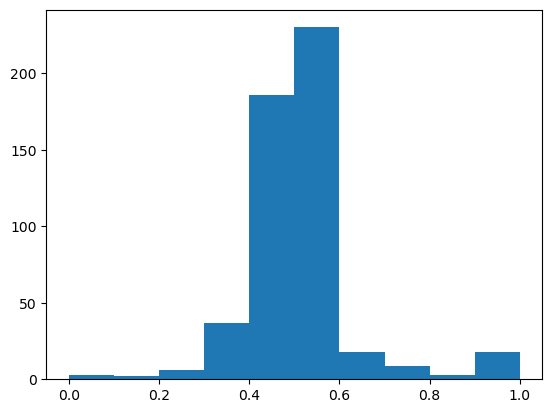

In [96]:
plt.hist(areas)

(array([ 13.,   1.,   8.,  21., 171., 266.,  11.,   6.,   1.,  14.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

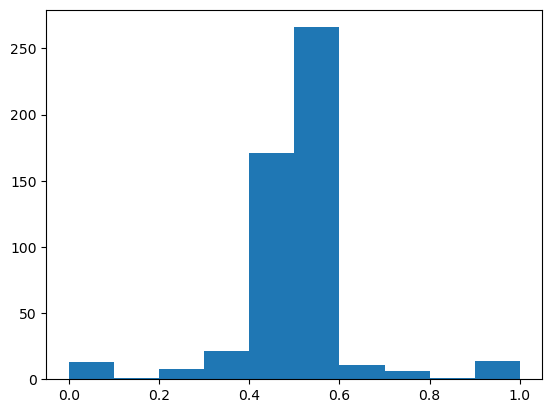

In [105]:
plt.hist(areas)